In [1]:
#pip install tensorflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#from pydmd import DMD
#from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, recall_score, precision_score, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', 10000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df = pd.read_csv('C:/Users/nikhi/Desktop/Machine Learning/project/data_stock market_machine learning.csv', index_col='Date', parse_dates=True)


In [4]:
pct_change = df.pct_change().dropna()

labels = pd.DataFrame(index=pct_change.index, columns=pct_change.columns)

for col in pct_change.columns:
    labels[col] = (df[col] > 0).astype(int)

In [5]:
pct_changePlusLabels = pd.concat([df, labels.add_suffix('_labels')], axis=1)

In [6]:

pct_changePlusLabels.head().append(pct_changePlusLabels.tail())



,INTC,SMTC,AWSL,MU,AMAT,ASML,NVDA,TXN,QCOM,AMD,INTC_labels,SMTC_labels,AWSL_labels,MU_labels,AMAT_labels,ASML_labels,NVDA_labels,TXN_labels,QCOM_labels,AMD_labels
Date,,,,,,,,,,,,,,,,,,,,
2000-01-02,0.15,-0.08,1.04,0.35,-0.23,-0.51,-0.48,-0.32,-0.33,-0.07,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2000-01-03,0.24,0.06,1.15,0.64,-0.12,-0.51,-0.48,-0.16,-0.35,-0.03,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2000-01-05,0.45,0.06,0.85,1.19,-0.03,-0.52,-0.48,-0.20,-0.50,0.36,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2000-01-06,0.46,0.13,0.52,1.61,-0.08,-0.52,-0.47,-0.19,-0.69,0.46,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2000-01-08,0.68,0.57,-0.21,1.92,-0.09,-0.51,-0.46,-0.24,-0.76,0.40,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2022-12-05,1.59,2.25,-0.51,2.19,3.02,2.97,2.99,2.59,2.70,2.86,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2022-12-07,1.34,2.31,-0.51,1.96,2.80,2.85,3.39,2.47,2.89,3.02,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2022-12-08,1.32,2.24,-0.50,2.02,2.97,3.03,3.42,2.69,2.99,3.29,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2022-12-09,1.10,1.96,-0.50,1.88,2.93,2.97,3.31,2.62,2.89,3.23,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


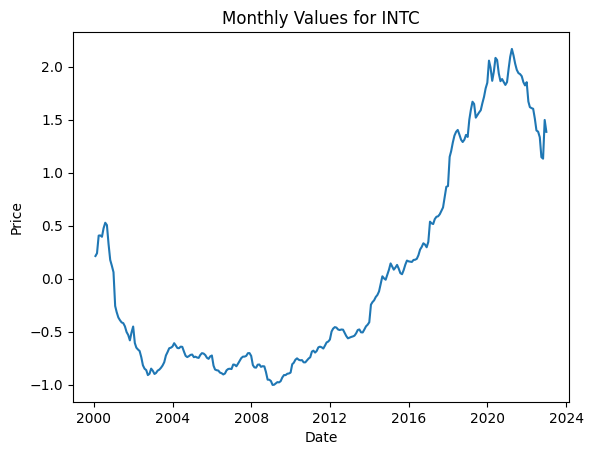

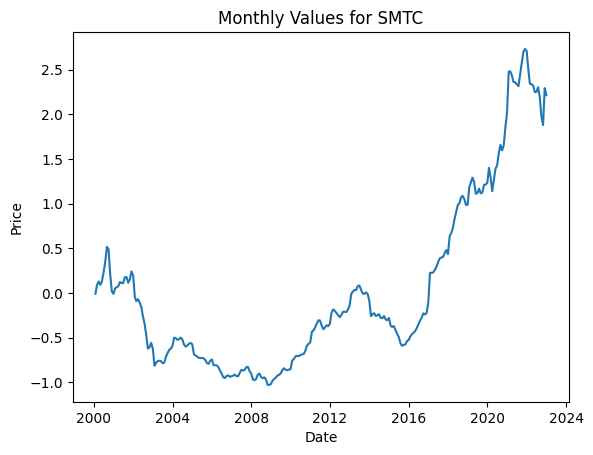

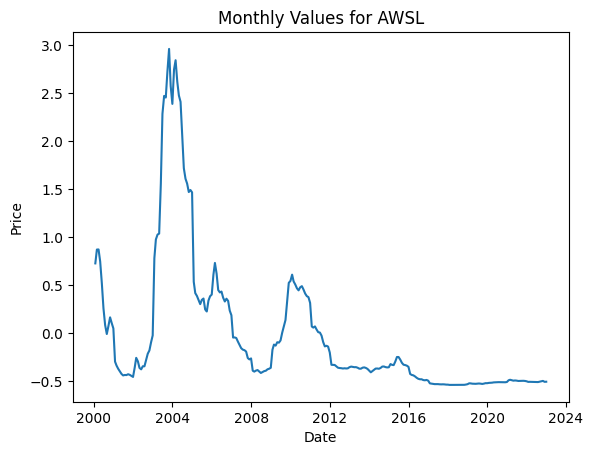

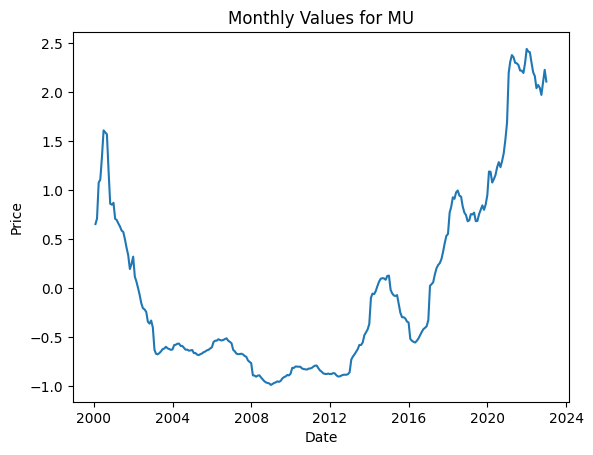

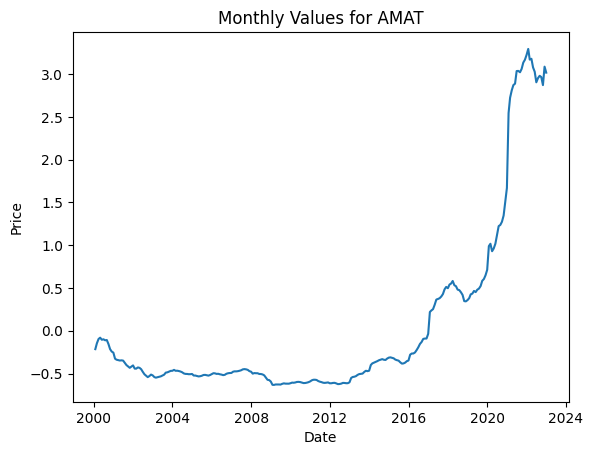

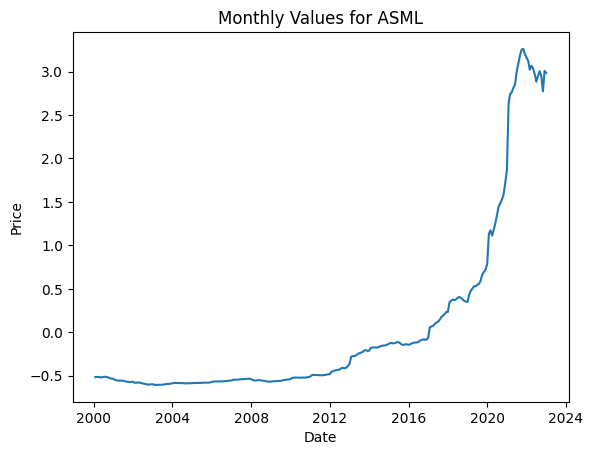

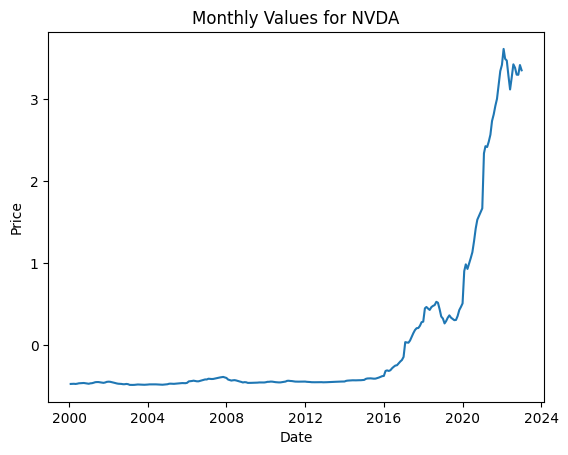

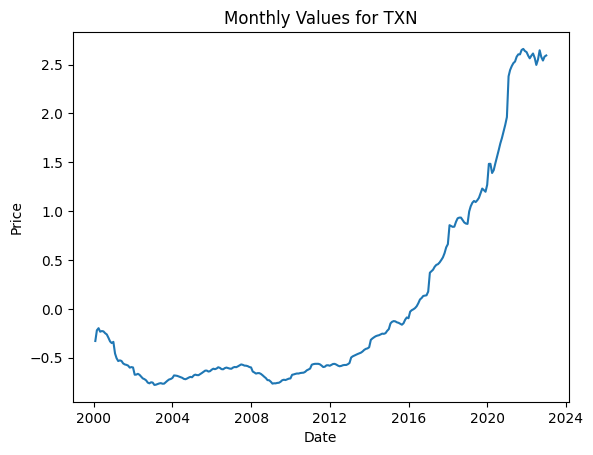

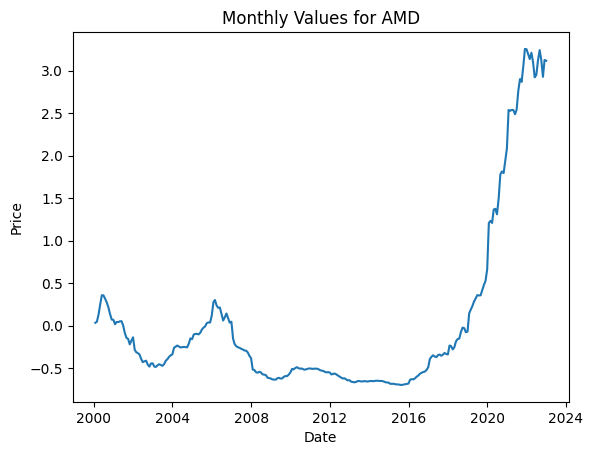

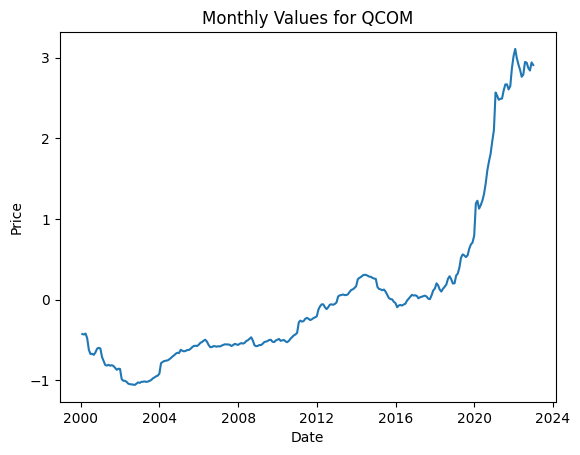

In [7]:
tickers = ['INTC','SMTC','AWSL', 'MU', 'AMAT', 'ASML','NVDA','TXN', 'AMD','QCOM']

for n in tickers:
    df_n = df[n].resample('M').mean().fillna(0)# what is M here and what are we fillna here doing?
    plt.plot(df_n.index, df_n)
    plt.title(f'Monthly Values for {n}')# are these graphs for years or months
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

<Figure size 640x480 with 0 Axes>

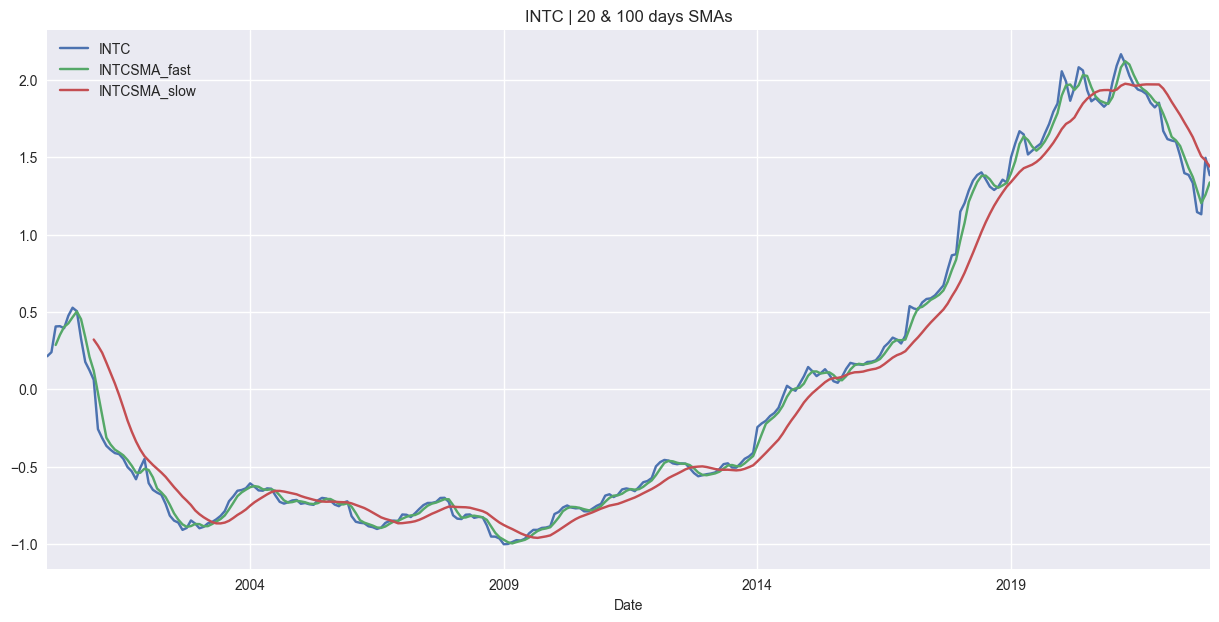

<Figure size 800x550 with 0 Axes>

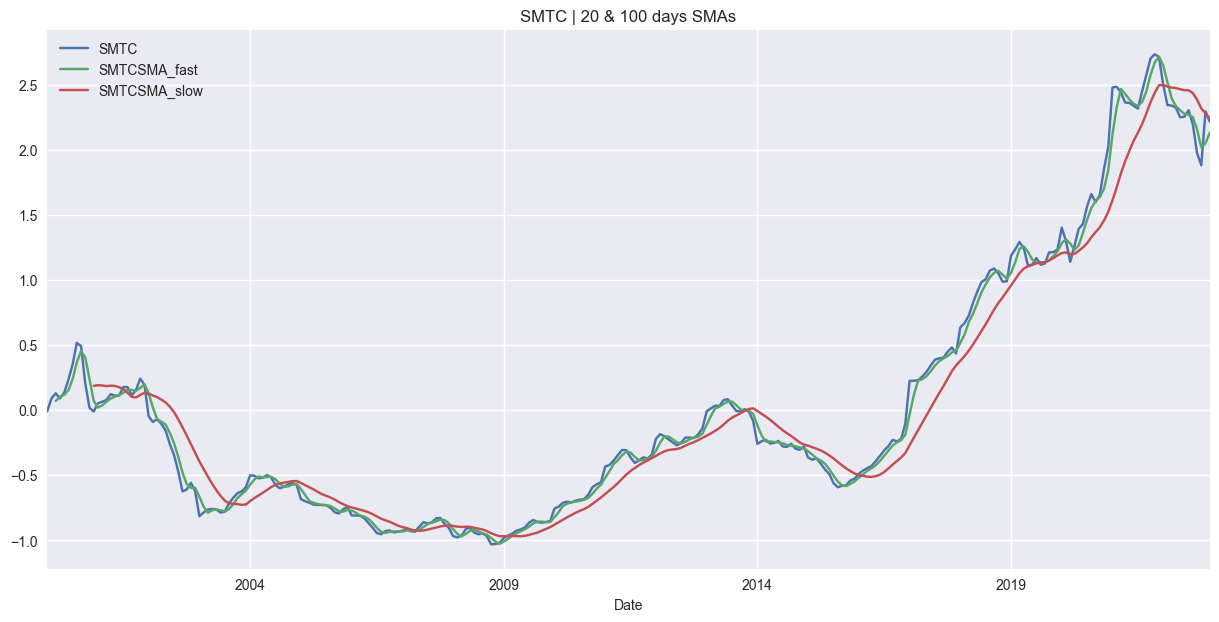

<Figure size 800x550 with 0 Axes>

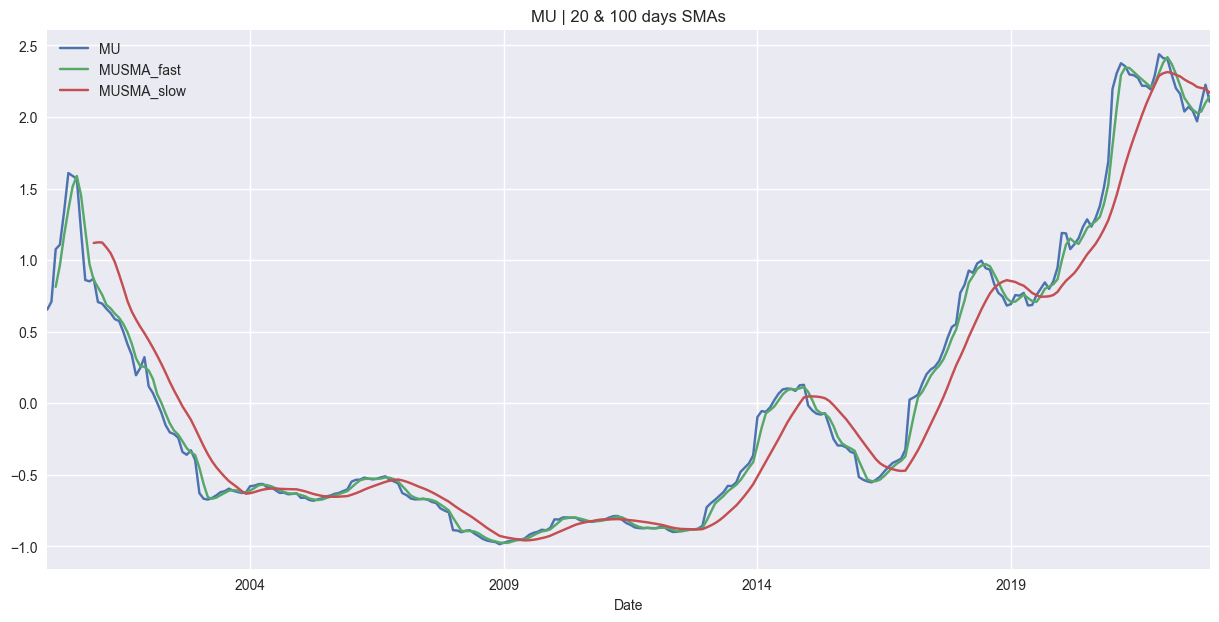

<Figure size 800x550 with 0 Axes>

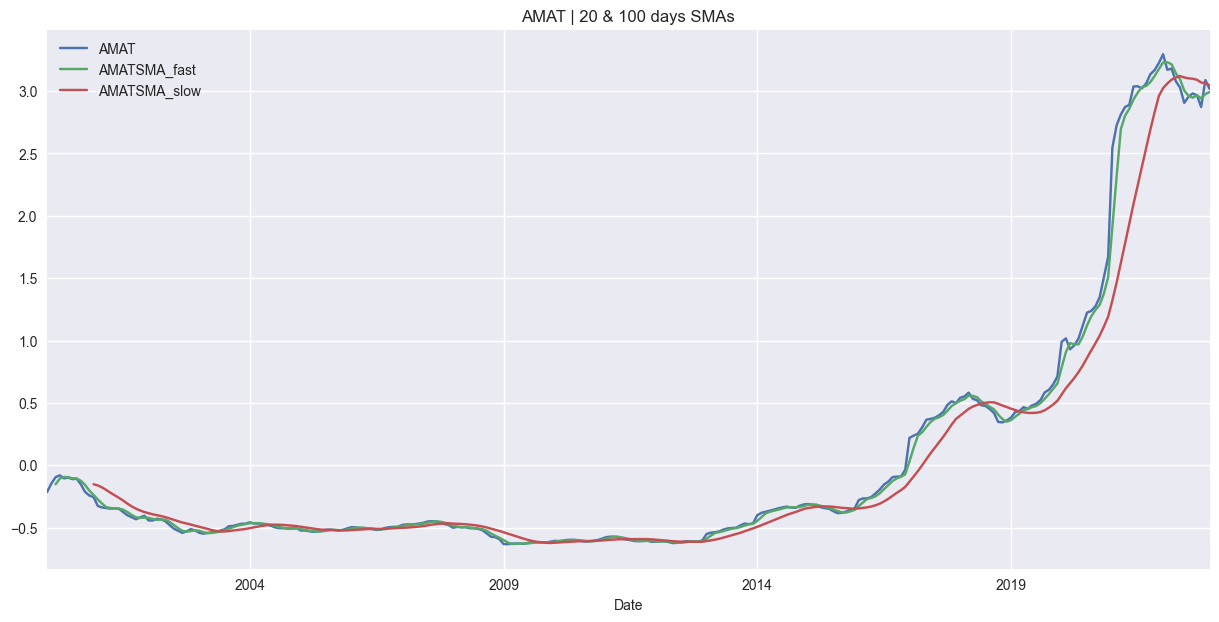

<Figure size 800x550 with 0 Axes>

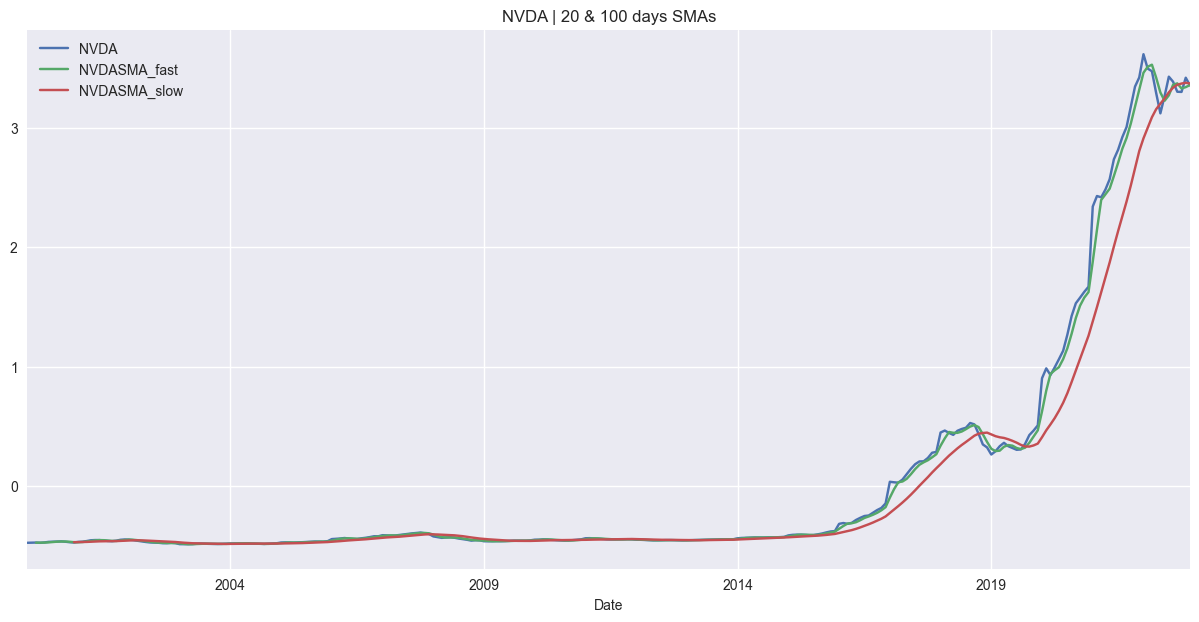

<Figure size 800x550 with 0 Axes>

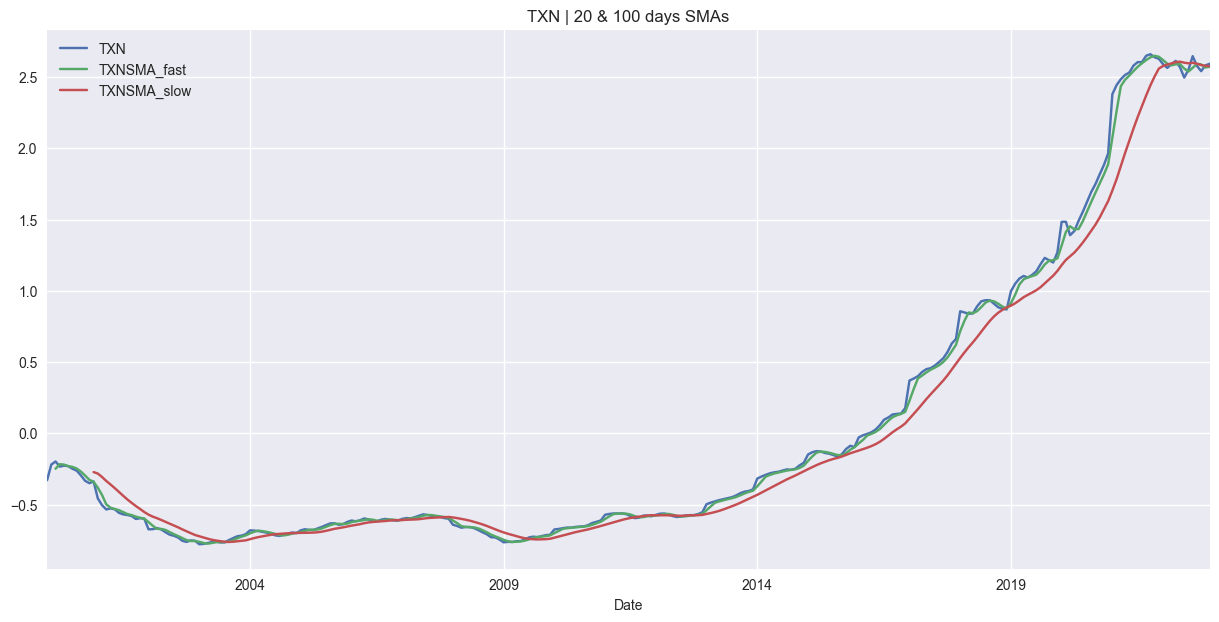

<Figure size 800x550 with 0 Axes>

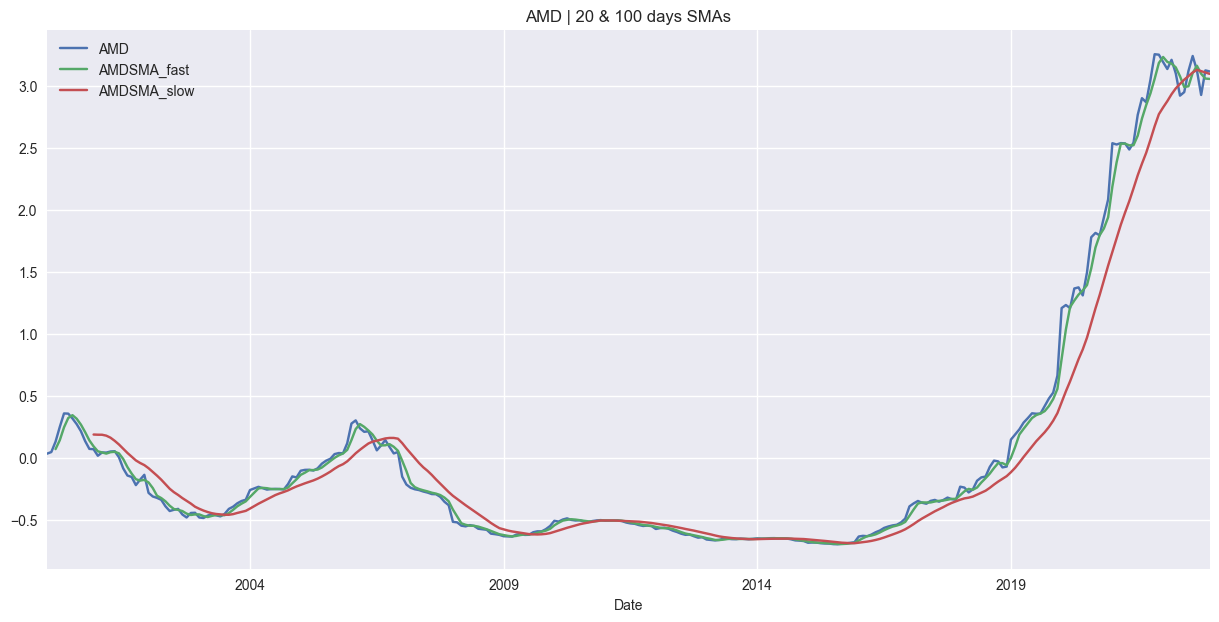

<Figure size 800x550 with 0 Axes>

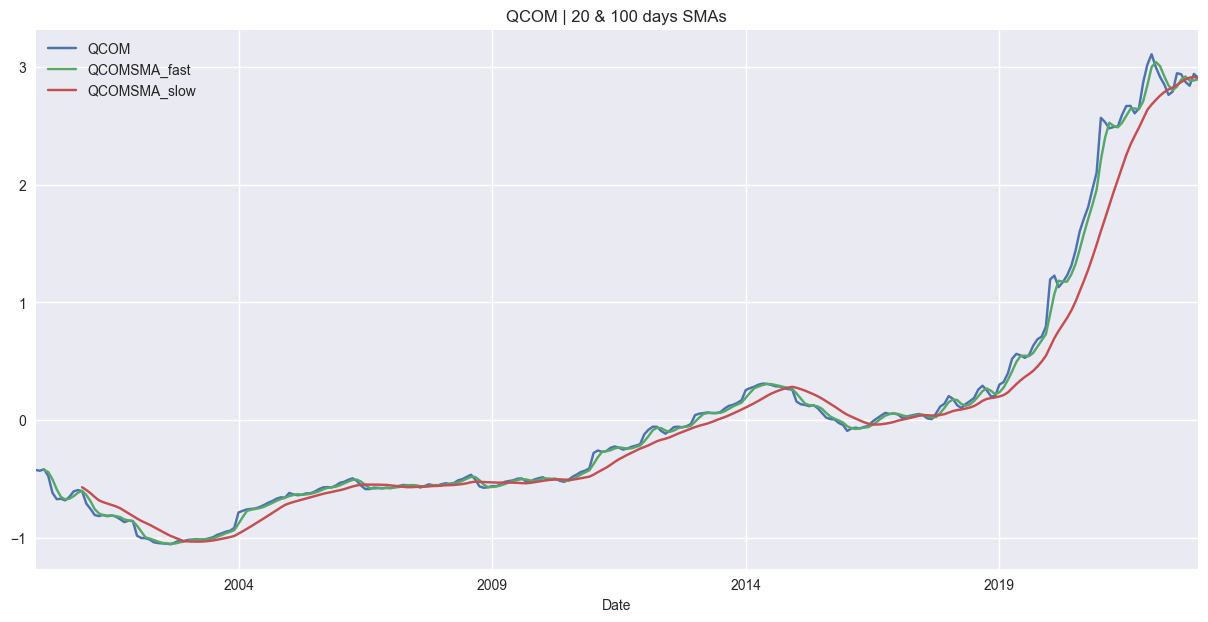

In [8]:

pd.options.display.float_format = '{:,.2f}'.format

tickers = ['INTC', 'SMTC', 'MU', 'AMAT', 'NVDA', 'TXN', 'AMD', 'QCOM']

df_monthly = df.resample('M').mean().fillna(0)

for n in tickers:
    df_monthly[f'{n}'+'SMA_fast'] = df_monthly[f'{n}'].rolling(3).mean()
    df_monthly[f'{n}'+'SMA_slow'] = df_monthly[f'{n}'].rolling(12).mean()

    plt.figure()
    plt.style.use('seaborn')
    df_monthly[[f'{n}', f'{n}SMA_fast', f'{n}SMA_slow']].plot(title=f'{n} | 20 & 100 days SMAs', figsize=(15, 7))
    plt.show()



In [9]:
df_monthly_labeled = pd.concat([df_monthly, df_n], axis=1).dropna(how='any')
#what is the meaning of labelling that is being done here?

df_labeled = pd.concat([df, labels.add_suffix('_label')], axis=1)



In [10]:
df_monthly_labeled.head()

,INTC,SMTC,AWSL,MU,AMAT,ASML,NVDA,TXN,QCOM,AMD,INTCSMA_fast,INTCSMA_slow,SMTCSMA_fast,SMTCSMA_slow,MUSMA_fast,MUSMA_slow,AMATSMA_fast,AMATSMA_slow,NVDASMA_fast,NVDASMA_slow,TXNSMA_fast,TXNSMA_slow,AMDSMA_fast,AMDSMA_slow,QCOMSMA_fast,QCOMSMA_slow,QCOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-12-31,0.06,-0.01,0.05,0.87,-0.26,-0.53,-0.47,-0.34,-0.60,0.07,0.12,0.32,0.07,0.19,0.86,1.12,-0.24,-0.15,-0.47,-0.47,-0.34,-0.27,0.09,0.19,-0.60,-0.57,-0.60
2001-01-31,-0.26,0.05,-0.29,0.71,-0.33,-0.55,-0.47,-0.46,-0.71,0.02,-0.02,0.28,0.02,0.19,0.81,1.12,-0.28,-0.16,-0.47,-0.47,-0.38,-0.28,0.05,0.18,-0.64,-0.59,-0.71
2001-02-28,-0.32,0.07,-0.34,0.70,-0.34,-0.55,-0.47,-0.50,-0.76,0.04,-0.17,0.24,0.04,0.19,0.76,1.12,-0.31,-0.18,-0.47,-0.47,-0.43,-0.31,0.04,0.18,-0.69,-0.62,-0.76
2001-03-31,-0.37,0.08,-0.37,0.66,-0.34,-0.56,-0.46,-0.53,-0.81,0.04,-0.31,0.17,0.07,0.19,0.69,1.09,-0.34,-0.20,-0.47,-0.47,-0.50,-0.33,0.03,0.18,-0.76,-0.65,-0.81
2001-04-30,-0.39,0.12,-0.40,0.63,-0.35,-0.56,-0.45,-0.53,-0.82,0.05,-0.36,0.10,0.09,0.19,0.66,1.05,-0.34,-0.22,-0.46,-0.47,-0.52,-0.36,0.04,0.16,-0.79,-0.68,-0.82


In [11]:
#df_labeled.head(15)

In [12]:
pct_changePlusLabels.head()

,INTC,SMTC,AWSL,MU,AMAT,ASML,NVDA,TXN,QCOM,AMD,INTC_labels,SMTC_labels,AWSL_labels,MU_labels,AMAT_labels,ASML_labels,NVDA_labels,TXN_labels,QCOM_labels,AMD_labels
Date,,,,,,,,,,,,,,,,,,,,
2000-01-02,0.15,-0.08,1.04,0.35,-0.23,-0.51,-0.48,-0.32,-0.33,-0.07,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2000-01-03,0.24,0.06,1.15,0.64,-0.12,-0.51,-0.48,-0.16,-0.35,-0.03,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2000-01-05,0.45,0.06,0.85,1.19,-0.03,-0.52,-0.48,-0.20,-0.50,0.36,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2000-01-06,0.46,0.13,0.52,1.61,-0.08,-0.52,-0.47,-0.19,-0.69,0.46,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2000-01-08,0.68,0.57,-0.21,1.92,-0.09,-0.51,-0.46,-0.24,-0.76,0.40,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [13]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# The data has still not been scaled at this point
df_labeled['Year'] = df_labeled.index.to_period('Y').year

train = df_labeled[df_labeled['Year'] < 2021].dropna(how='any')
test = df_labeled[df_labeled['Year'] >= 2021].dropna(how='any') 


In [14]:
len(train)

5283

In [15]:
len(test)

460

In [16]:
# in some places we are doing for AMD and below we are doing for INTC only
scaled = StandardScaler()

train_scaled = pd.DataFrame(scaled.fit_transform(train), columns = train.columns, index = train.index).dropna(how='any')
test_scaled = pd.DataFrame(scaled.transform(test), columns = test.columns, index = test.index).dropna(how='any')


"""history = list(train['AMD'])
predictions = []
for t in range(len(test)):
    model = ARIMA(history,order = (1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_hat = output[0]
    print(y_hat)
    predictions.append(y_hat)
    obs = test['AMD'].iloc[t]
    history.append(obs)
arima_model = pd.DataFrame(predictions)""
"""

'history = list(train[\'AMD\'])\npredictions = []\nfor t in range(len(test)):\n    model = ARIMA(history,order = (1,1,1))\n    model_fit = model.fit()\n    output = model_fit.forecast()\n    y_hat = output[0]\n    print(y_hat)\n    predictions.append(y_hat)\n    obs = test[\'AMD\'].iloc[t]\n    history.append(obs)\narima_model = pd.DataFrame(predictions)""\n'

In [17]:
VarModel = sm.tsa.VAR(train)
lags = VarModel.select_order(maxlags=12)
results = VarModel.fit(lags.selected_orders['aic'])

pred = results.forecast(test.values, len(test))
pred

c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


array([[ 1.06797195e+00,  1.63130129e+00, -6.74895663e-01, ...,
         9.42663440e-01,  8.45602070e-01,  2.02195784e+03],
       [ 1.05331493e+00,  1.47324446e+00, -6.77949029e-01, ...,
         9.12151777e-01,  5.56787174e-01,  2.02191245e+03],
       [ 1.08166679e+00,  1.45938060e+00, -6.24655443e-01, ...,
         9.87399958e-01,  3.68818764e-01,  2.02186591e+03],
       ...,
       [ 1.77665806e+00,  1.36839974e+00, -5.24731578e-01, ...,
         1.15974944e+00,  8.47136734e-01,  2.02155001e+03],
       [ 1.77740317e+00,  1.36905784e+00, -5.25486175e-01, ...,
         1.16022082e+00,  8.47302562e-01,  2.02155159e+03],
       [ 1.77814668e+00,  1.36971401e+00, -5.26237723e-01, ...,
         1.16069135e+00,  8.47467322e-01,  2.02155317e+03]])

In [18]:
def error_metrics(labels, predictions, modelName):
  rmse = np.sqrt(mean_squared_error(labels, predictions))
  r2 = r2_score(labels, predictions)

  print(f'mean_squared_error {rmse} for model{modelName}')
  print(f'r2_error {r2} for model{modelName}')

In [19]:
error_metrics(test, pred, 'VarModel')

mean_squared_error 1.0021430124208313 for modelVarModel
r2_error -41.8269034027738 for modelVarModel


In [20]:
 pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\nikhi\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [21]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
tickers = ['INTC','SMTC','AWSL', 'MU', 'AMAT', 'ASML','NVDA','TXN', 'AMD','QCOM']
for t in  tickers:
  
 #here train_scaled contains only INTC
  print(train_scaled)
  print(f'running model on {t}_ticker')

  arima_model = auto_arima(train_scaled, sesonal=False)
  arima_pred = arima_model.predict(n_periods=len(test_scaled))
  arima_pred = pd.DataFrame(arima_pred)
  print(f'Error metrics for {t}')
  error_metrics(test_scaled, arima_pred, 'arima_model')

            INTC  SMTC  AWSL    MU  AMAT  ASML  NVDA   TXN  QCOM   AMD  INTC_label  SMTC_label  AWSL_label  MU_label  AMAT_label  ASML_label  NVDA_label  TXN_label  QCOM_label  AMD_label  Year
Date                                                                                                                                                                                            
2000-01-02  0.34  0.15  1.25  0.75  0.05 -0.52 -0.51 -0.14 -0.16  0.33        1.37       -0.68        1.44      1.43       -0.49       -0.48       -0.46      -0.53       -0.70      -0.53 -1.65
2000-01-03  0.46  0.36  1.39  1.15  0.27 -0.52 -0.51  0.10 -0.19  0.41        1.37        1.48        1.44      1.43       -0.49       -0.48       -0.46      -0.53       -0.70      -0.53 -1.65
2000-01-05  0.69  0.36  1.02  1.92  0.45 -0.53 -0.51  0.04 -0.46  1.16        1.37        1.48        1.44      1.43       -0.49       -0.48       -0.46      -0.53       -0.70       1.90 -1.65
2000-01-06  0.71  0.46  0.62  2.50 

ValueError: y should be a 1d array, got an array of shape (5283, 21) instead.

In [ ]:
error_metrics(test_scaled, arima_pred, 'arima_model')# only for INTC

NameError: name 'arima_pred' is not defined

In [ ]:
train_scaled.head()

,INTC,SMTC,AWSL,MU,AMAT,ASML,NVDA,TXN,QCOM,AMD,INTC_label,SMTC_label,AWSL_label,MU_label,AMAT_label,ASML_label,NVDA_label,TXN_label,QCOM_label,AMD_label,Year
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,0.34,0.15,1.25,0.75,0.05,-0.52,-0.51,-0.14,-0.16,0.33,1.37,-0.68,1.44,1.43,-0.49,-0.48,-0.46,-0.53,-0.70,-0.53,-1.65
2000-01-03,0.46,0.36,1.39,1.15,0.27,-0.52,-0.51,0.10,-0.19,0.41,1.37,1.48,1.44,1.43,-0.49,-0.48,-0.46,-0.53,-0.70,-0.53,-1.65
2000-01-05,0.69,0.36,1.02,1.92,0.45,-0.53,-0.51,0.04,-0.46,1.16,1.37,1.48,1.44,1.43,-0.49,-0.48,-0.46,-0.53,-0.70,1.90,-1.65
2000-01-06,0.71,0.46,0.62,2.50,0.35,-0.53,-0.50,0.05,-0.77,1.34,1.37,1.48,1.44,1.43,-0.49,-0.48,-0.46,-0.53,-0.70,1.90,-1.65
2000-01-08,0.96,1.08,-0.29,2.92,0.34,-0.52,-0.48,-0.03,-0.89,1.23,1.37,1.48,-0.69,1.43,-0.49,-0.48,-0.46,-0.53,-0.70,1.90,-1.65


In [ ]:
df = pd.read_csv('C:/Users/nikhi/Desktop/Machine Learning/project/data_stock market_machine learning.csv', index_col='Date', parse_dates=True)

df['year'] = df.index.to_period('Y').year

train = df[df['year'] < 2021]
test = df[df['year'] >= 2021]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['AMD']])
test_scaled = scaler.transform(test[['AMD']])

In [ ]:

# RNN
look_back = 5
train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=look_back, batch_size=1)
test_gen = TimeseriesGenerator(test_scaled, test_scaled, length=look_back, batch_size=1)

# RNN
rnn = Sequential()
rnn.add(LSTM(50, activation='relu', input_shape=(5, 1)))
rnn.add(Dense(train.shape[1]))
rnn.compile(optimizer='adam', loss='mse')

rnn.fit(train_gen, epochs=50, verbose=0)

rnn_preds = []
for i in range(len(test_gen)):
    rnn_preds.append(rnn.predict(test_gen[i][0]))
rnn_preds = np.squeeze(np.array(rnn_preds))
rnn_preds = scaler.inverse_transform(rnn_preds)


1/1 [==============================] - 0s 14ms/step


In [ ]:
error_metrics(test_gen.targets, rnn_preds, 'RNN')


ValueError: Found input variables with inconsistent numbers of samples: [460, 455]

In [ ]:
rnn_predictions = []
for i in range(len(test_gen)):
  X_test, y_test = test_gen[i]
  pre = rnn.predict(X_test[:455])
  rnn_predictions.append(pre[0])  


rnn_predict = np.array(rnn_predictions)
error_metrics(test_gen.targets, rnn_predict, 'RNN')



1/1 [==============================] - 0s 15ms/step


ValueError: Found input variables with inconsistent numbers of samples: [460, 455]

In [ ]:
#pip install pydmd

In [ ]:
from pydmd import DMD
dmd = DMD()

In [ ]:

from pandas.core.common import random_state
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import  GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

tickers = ['INTC','SMTC','AWSL', 'MU', 'AMAT', 'ASML','NVDA','TXN', 'AMD','QCOM']
#MUSMA_fast	MUSMA_slow	

X = pct_changePlusLabels[["NVDA"]].dropna(how='all')
y = pct_changePlusLabels[['NVDA_labels']].dropna(how='all')



In [ ]:
len(X)
X.head(10)

,NVDA
Date,
2000-01-02,-0.48
2000-01-03,-0.48
2000-01-05,-0.48
2000-01-06,-0.47
2000-01-08,-0.46
2000-01-09,-0.46
2000-01-11,-0.47
2000-01-12,-0.47
2000-01-13,-0.48


In [ ]:

def plot_confusion_matrix(matrix, model_name):
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_title(f"Confusion Matrix for {model_name}", fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

    plt.show()# why is the figure not showing here?

Accuraccy of voting classifer on test set: %99.30362116991644
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1099
         1.0       1.00      0.97      0.98       337

    accuracy                           0.99      1436
   macro avg       0.99      0.99      0.99      1436
weighted avg       0.99      0.99      0.99      1436



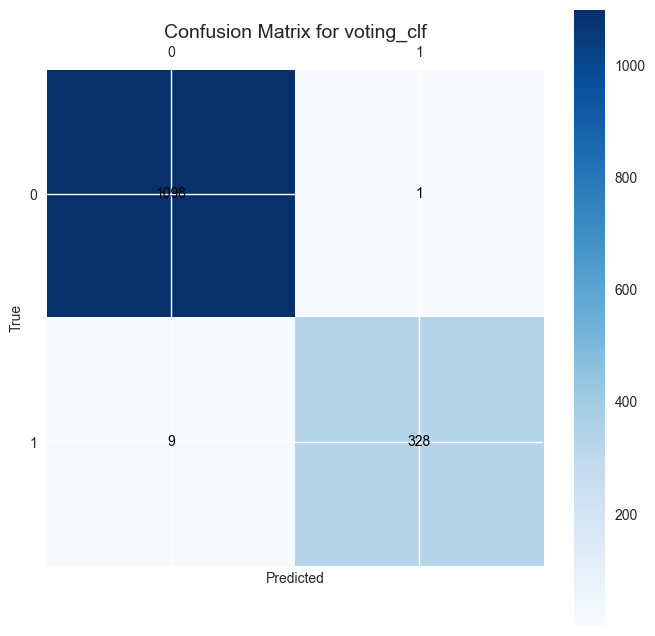

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X[:5743], y)

lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier(random_state=25)
#gr_clf = GradientBoostingClassifier()

#voting_clf = VotingClassifier(estimators=[('lr', lr_clf),('rf', rf_clf)], voting='hard') # ('gr', gr_clf)

lr_clf.fit(X_train,y_train)

pre = lr_clf.predict(X_test)

print(f"Accuraccy of voting classifer on test set: %{lr_clf.score(X_test, y_test) * 100}")
print(classification_report(y_test, pre))
cm = confusion_matrix(y_test, pre)
plot_confusion_matrix(cm, 'voting_clf')



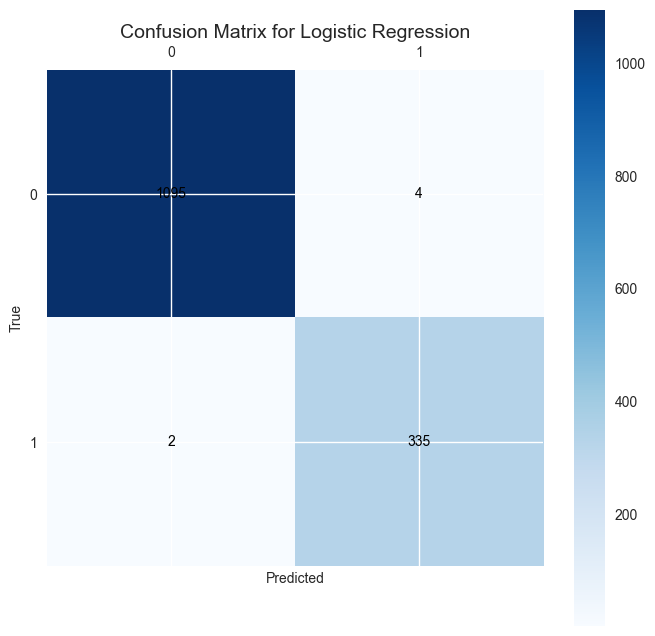

Logistic Regression accuracy: 0.9958217270194986
[[1095    4]
 [   2  335]]


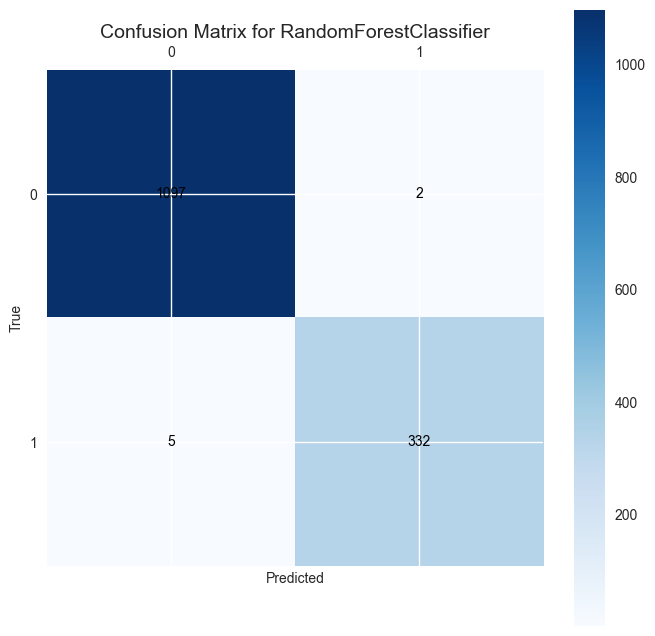

RandomForestClassifier accuracy: 0.995125348189415
[[1097    2]
 [   5  332]]


In [ ]:
nonscaledvalues = pd.DataFrame(columns=['Model', 'Prediction', 'Accuracy'])

models_CM = {
    "Logistic Regression": LogisticRegression(max_iter=1000,random_state=42,class_weight='balanced'),
    "RandomForestClassifier": RandomForestClassifier(random_state=42), # class_weight=cost_matrix
 }


for model_name, model in models_CM.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)

    print(f"{model_name} accuracy: {accuracy}\n{cm}")
    nonscaledvalues = nonscaledvalues.append(
        {'Model': model, 'Prediction': y_pred, 'Accuracy': accuracy},
        ignore_index=True
    )



In [ ]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import make_scorer

np.random.seed(42)


def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='Date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits
    

In [ ]:
def rank_correl(y_, y_pred):
    return spearmanr(y_, y_pred)[0]
ic = make_scorer(rank_correl)

In [ ]:
df_monthly.columns

Index(['INTC', 'SMTC', 'AWSL', 'MU', 'AMAT', 'ASML', 'NVDA', 'TXN', 'QCOM', 'AMD', 'INTCSMA_fast', 'INTCSMA_slow', 'SMTCSMA_fast', 'SMTCSMA_slow', 'MUSMA_fast', 'MUSMA_slow', 'AMATSMA_fast', 'AMATSMA_slow', 'NVDASMA_fast', 'NVDASMA_slow', 'TXNSMA_fast', 'TXNSMA_slow', 'AMDSMA_fast', 'AMDSMA_slow', 'QCOMSMA_fast', 'QCOMSMA_slow'], dtype='object')

In [ ]:
#df_monthly
#train = df[df['year'] < 2021]
#test = df[df['year'] >= 2021]

X = df_monthly[["NVDA"]].fillna(0)
y = df_monthly[['NVDASMA_fast']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [ ]:

n_splits = 5
train_period_length = 30
test_period_length = 10
lookahead = 1

max_depths = range(1, 16)

param_grid = {'n_estimators': [50, 100, 250],
             'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15, None],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': ['sqrt', 'auto']}



cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)


rf_reg = RandomForestRegressor(n_estimators=100, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

gridsearch_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                      cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)
rf_reg.fit(X=X_train, y=y_train)

gridsearch_reg.fit(X=X_train, y=y_train)

cv_score = cross_val_score(estimator=rf_reg,
                           X=X_test,
                           y=y_test,
                           scoring=ic,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)


rf_clf = RandomForestClassifier(n_estimators=100,          
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, 
                                oob_score=True)


gridsearch_clf = GridSearchCV(estimator=rf_clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=cv,
                          refit=True,
                          return_train_score=True);
rf_clf.fit(X=X, y=y)
gridsearch_clf.fit(X=X, y=y)


cv_scoreclf = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)



pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

Fitting 5 folds for each of 264 candidates, totalling 1320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


IndexError: list index out of range